In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nitishkd","key":"43419bc8e210070cef36b2f1db9201db"}'}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d jaimebadiola/bitcoin-tweets-and-price

  0% 0.00/739k [00:00<?, ?B/s]
100% 739k/739k [00:00<00:00, 47.9MB/s]


In [0]:
!unzip bitcoin-tweets-and-price.zip

Archive:  bitcoin-tweets-and-price.zip
  inflating: Data_To_Hourervals_no_filter.csv  


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Library for Learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error


Using TensorFlow backend.


In [0]:
coinbase = pd.read_csv("Data_To_Hourervals_no_filter.csv",sep=";")
cb_index = coinbase.index.ravel()

print(list(coinbase.columns), "\nSHAPE ::", coinbase.shape)
for i in coinbase.columns:
    print(i, "::", coinbase[i].dtype)

# Declaring number for random state for reproducibility
rstate=123

coinbase.head()


['Date', 'Compound_Score', 'n', 'Count_Negatives', 'Count_Positives', 'Count_Neutrals', 'Sent_Negatives', 'Sent_Positives', 'Open', 'High', 'Low', 'Close', 'Volume (BTC)', 'Volume (Currency)'] 
SHAPE :: (12936, 14)
Date :: object
Compound_Score :: float64
n :: float64
Count_Negatives :: float64
Count_Positives :: float64
Count_Neutrals :: float64
Sent_Negatives :: float64
Sent_Positives :: float64
Open :: float64
High :: float64
Low :: float64
Close :: float64
Volume (BTC) :: object
Volume (Currency) :: object


,Date,Compound_Score,n,Count_Negatives,Count_Positives,Count_Neutrals,Sent_Negatives,Sent_Positives,Open,High,Low,Close,Volume (BTC),Volume (Currency)
0,01/08/2017 0:00,0.097156,1027.0,148.0,403.0,476.0,-0.504061,0.432704,2855.81,2863.06,2823.00,2825.92,184.02,"522951,00"
1,01/08/2017 1:00,0.064507,778.0,143.0,239.0,396.0,-0.381007,0.437953,2823.01,2860.02,2821.01,2853.38,77.3,219605.16
2,01/08/2017 2:00,0.119218,836.0,118.0,333.0,385.0,-0.394999,0.439269,2846.27,2858.04,2837.31,2841.60,135.83,386739.15
3,01/08/2017 3:00,0.004163,984.0,262.0,279.0,443.0,-0.431913,0.420278,2841.84,2863.88,2837.73,2862.93,143.2,408360.03
4,01/08/2017 4:00,0.065608,751.0,133.0,237.0,381.0,-0.405835,0.435645,2862.92,2876.00,2848.11,2874.99,222.53,637045.88


In [0]:
df = coinbase
df[df[:]==""] = np.NaN
a = df.fillna(method='ffill')
a = a.drop(['Date'], axis=1)
# Volume (Currency)
a = a.drop(["Volume (Currency)"], axis=1)
a = a.drop(["Volume (BTC)"], axis=1)
old_a = a
print(a.head())
# SC = MinMaxScaler()
# a = SC.fit_transform(a)
a = a.values


   Compound_Score       n  Count_Negatives  Count_Positives  Count_Neutrals  \
0        0.097156  1027.0            148.0            403.0           476.0   
1        0.064507   778.0            143.0            239.0           396.0   
2        0.119218   836.0            118.0            333.0           385.0   
3        0.004163   984.0            262.0            279.0           443.0   
4        0.065608   751.0            133.0            237.0           381.0   

   Sent_Negatives  Sent_Positives     Open     High      Low    Close  
0       -0.504061        0.432704  2855.81  2863.06  2823.00  2825.92  
1       -0.381007        0.437953  2823.01  2860.02  2821.01  2853.38  
2       -0.394999        0.439269  2846.27  2858.04  2837.31  2841.60  
3       -0.431913        0.420278  2841.84  2863.88  2837.73  2862.93  
4       -0.405835        0.435645  2862.92  2876.00  2848.11  2874.99  


(12936, 4)


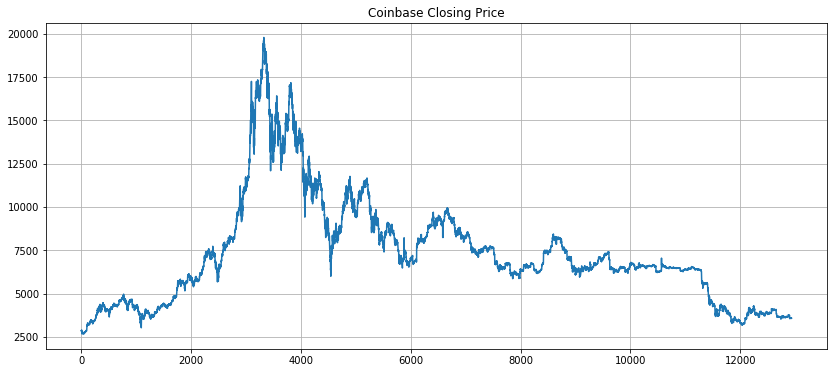

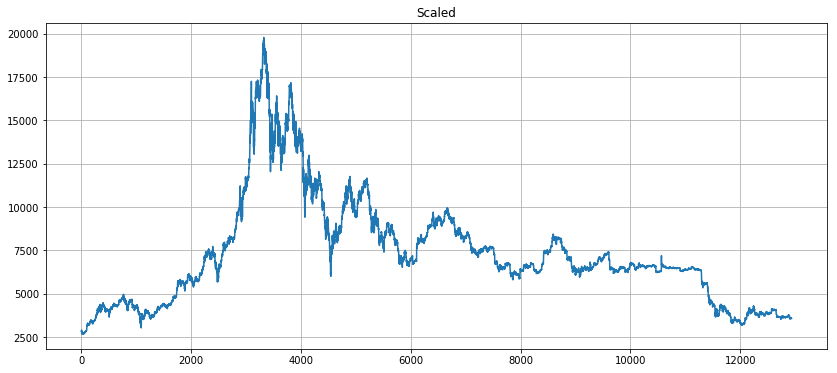

In [0]:
close_price = a[:, 7].reshape(-1,1)
plt.figure(figsize=(14,6))
plt.title("Coinbase Closing Price")
plt.grid()
plt.plot(close_price)

new_dataset = a[:, [2,3,4,10]]
# sc = MinMaxScaler()
# close_priceSC = sc.fit_transform(new_dataset)
close_priceSC = new_dataset
plt.figure(figsize=(14,6))
plt.title("Scaled")
plt.grid()
print(close_priceSC.shape)
plt.plot(close_priceSC[:, 3])

In [0]:
Y_dash = (np.array(close_priceSC[:, 3])).reshape(-1,1)
X = []
Y = []
close_priceSC = close_priceSC[:]
sc1 = MinMaxScaler()
close_priceSC = sc1.fit_transform(close_priceSC)
sc2 = MinMaxScaler()
print(close_priceSC.shape)
Y_dash = sc2.fit_transform(Y_dash)

for i in range(60, len(close_priceSC)):
    U = close_priceSC[i-60:i, :]
    X.append(U)   
    Y.append(Y_dash[i])
X = np.array(X)
Y = np.array(Y)
    
    

(12936, 4)


In [0]:
np.unique(close_priceSC)

array([0.00000000e+00, 2.04708291e-04, 2.10372166e-04, ...,
       9.96677873e-01, 1.00000000e+00, 1.00000000e+00])

In [0]:
print(X.shape)
X_train = X[:10000]
X_test = X[10000:]

y_train = Y[:10000]
y_test = Y[10000:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12876, 60, 4)
(10000, 60, 4)
(10000, 1)
(2876, 60, 4)
(2876, 1)


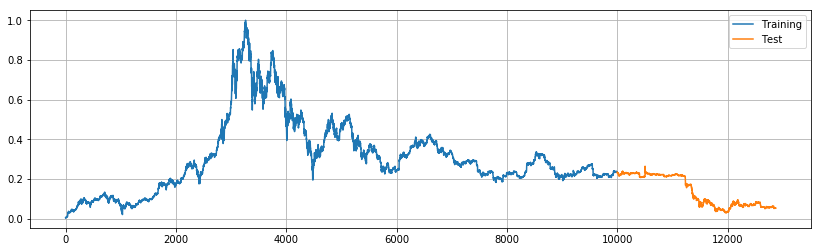

In [0]:
plt.figure(figsize=(14,4))
plt.plot(range(10000),y_train)
plt.plot(range(10000, len(X)), y_test)
plt.legend(["Training", "Test"])
plt.grid()


In [0]:
print(X_train.shape)
# X_train = X_train.reshape(-1,60,3)
# X_test = X_test.reshape(-1,60,3)

(10000, 60, 4)


In [0]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=200, batch_size=1000)

Epoch 1/200
10000/10000 [==============================] - 8s 775us/step - loss: 0.1843
Epoch 2/200
10000/10000 [==============================] - 3s 336us/step - loss: 0.1003
Epoch 3/200
10000/10000 [==============================] - 3s 335us/step - loss: 0.0689
Epoch 4/200
10000/10000 [==============================] - 3s 336us/step - loss: 0.0545
Epoch 5/200
10000/10000 [==============================] - 3s 335us/step - loss: 0.0486
Epoch 6/200
10000/10000 [==============================] - 3s 348us/step - loss: 0.0453
Epoch 7/200
10000/10000 [==============================] - 3s 334us/step - loss: 0.0435
Epoch 8/200
10000/10000 [==============================] - 3s 337us/step - loss: 0.0411
Epoch 9/200
10000/10000 [==============================] - 3s 334us/step - loss: 0.0396
Epoch 10/200
10000/10000 [==============================] - 3s 336us/step - loss: 0.0389
Epoch 11/200
10000/10000 [==============================] - 3s 335us/step - loss: 0.0382
Epoch 12/200
10000/10000 [====

In [0]:
# regressor = tf.keras.models.load_model('model.h5')

In [0]:
%%time
y_pred = regressor.predict(X_test)
print(y_pred.shape, X_test.shape)

(2876, 1) (2876, 60, 4)
CPU times: user 19.5 s, sys: 1.45 s, total: 21 s
Wall time: 13.4 s


In [0]:
def systematic_mean_absolute_percentage_error(y_true, y_pred):
    n = y_true.shape[0]
    res = 0
    for i in range(n):
        num = np.abs(y_pred[i] - y_true[i])
        dem = (np.abs(y_true[i]) + np.abs(y_pred[i]))/2
        res += num/dem
    res = np.squeeze(res)
    return 100*(res/n)

In [0]:
import numpy as np
def mean_absolute_scaled_error(y_true, y_pred):
    n = y_true.shape[0]
    res = 0
    dem = 0
    num = 0
    for i in range(n-1):
        dem += y_true[i+1] - y_true[i]
    for i in range(n):
        num = abs(y_pred[i] - y_true[i])
        num = np.squeeze(num)
        res += num/dem
    res = np.squeeze(res)
    #print(num, dem, res)
    return res/n

In [0]:
MAE = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error is : ", MAE)

Mean Absolute Error is :  0.0077981208505115045


Text(0, 0.5, 'Price')

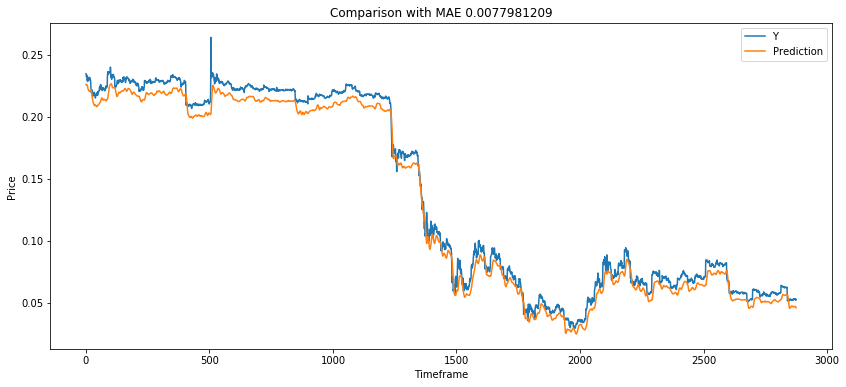

In [0]:
plt.figure(figsize=(14,6))
plt.plot(y_test)
plt.plot(y_pred)
plt.plot()
plt.title("Comparison with MAE {0:0.10f}".format(MAE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [0]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, y_pred)
print("Mean Squared Error is : ", MSE)

Mean Squared Error is :  7.203649901261506e-05


In [0]:
SMAPE = systematic_mean_absolute_percentage_error(y_test, y_pred)
print("Systematic Mean Absolute Percentage Error is : ", SMAPE)

Systematic Mean Absolute Percentage Error is :  7.853745351973668


In [0]:
MASE = mean_absolute_scaled_error(y_test, y_pred)
print("Mean Absolute Scaled Error is : ",MASE)

Mean Absolute Scaled Error is :  -0.04280366978592779


Text(0, 0.5, 'Price')

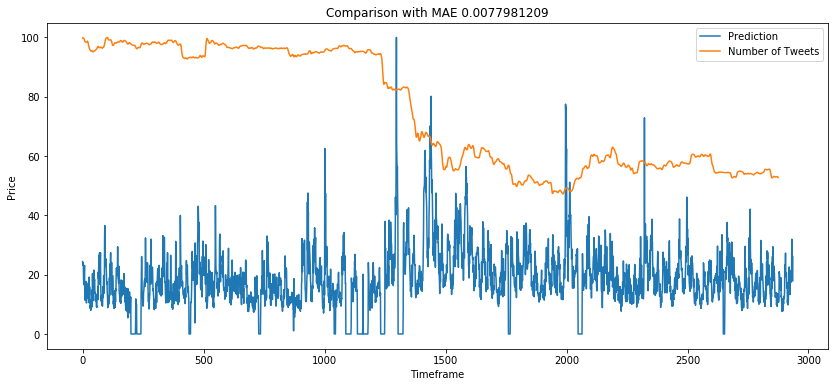

In [95]:
plt_tweet_cnt = X_test[:, 0]

Y_pred_inverse = sc2.inverse_transform(y_pred)
# X_test_inv = sc1.inverse_transform(X_test)

tweet_count= new_dataset[10000:, 0]
plt_y_pred = Y_pred_inverse
tweet_count2 = (tweet_count/(max(tweet_count)))*100
plt_y_pred = (plt_y_pred/max(plt_y_pred))*100
plt.figure(figsize=(14,6))
plt.plot(tweet_count2)
plt.plot(plt_y_pred)

plt.title("Comparison with MAE {0:0.10f}".format(MAE))
plt.legend(["Prediction", "Number of Tweets"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

Text(0, 0.5, 'Price')

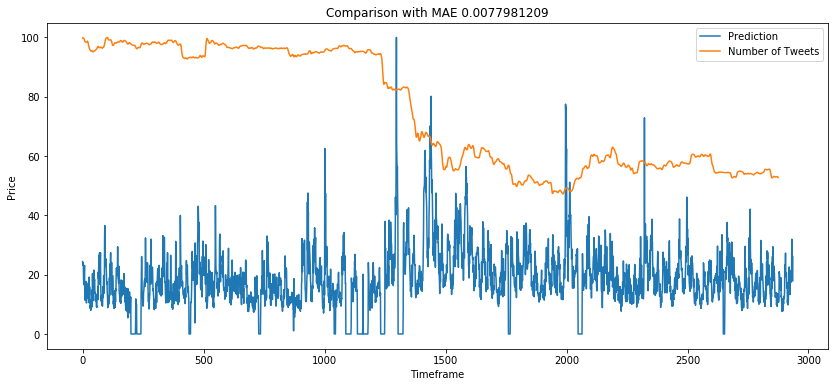

In [89]:
tweet_count= new_dataset[10000:, 0]
plt_y_pred = Y_pred_inverse
tweet_count2 = (tweet_count/(max(tweet_count)))*100
plt_y_pred = (plt_y_pred/max(plt_y_pred))*100
plt.figure(figsize=(14,6))
plt.plot(tweet_count2)
plt.plot(plt_y_pred)

plt.title("Comparison with MAE {0:0.10f}".format(MAE))
plt.legend(["Prediction", "Number of Tweets"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

Text(0, 0.5, 'Price')

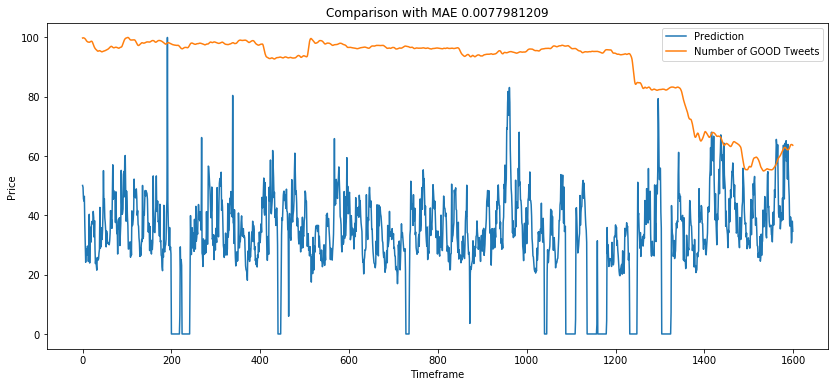

In [94]:
tweet_count= new_dataset[10000:, 1]
plt_y_pred = Y_pred_inverse
tweet_count2 = (tweet_count/(max(tweet_count)))*100
plt_y_pred = (plt_y_pred/max(plt_y_pred))*100
plt.figure(figsize=(14,6))
plt.plot(tweet_count2[:1600])
plt.plot(plt_y_pred[:1600])

plt.title("Comparison with MAE {0:0.10f}".format(MAE))
plt.legend(["Prediction", "Number of GOOD Tweets"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

Text(0, 0.5, 'Price')

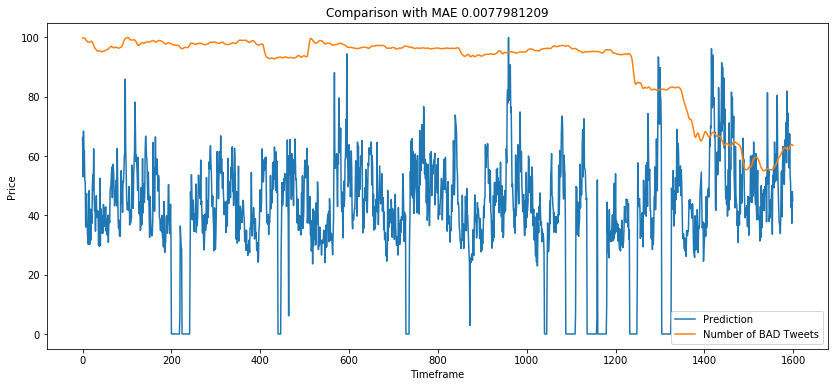

In [93]:
tweet_count= new_dataset[10000:, 2]
plt_y_pred = Y_pred_inverse
tweet_count2 = (tweet_count/(max(tweet_count)))*100
plt_y_pred = (plt_y_pred/max(plt_y_pred))*100
plt.figure(figsize=(14,6))
plt.plot(tweet_count2[:1600])
plt.plot(plt_y_pred[:1600])

plt.title("Comparison with MAE {0:0.10f}".format(MAE))
plt.legend(["Prediction", "Number of BAD Tweets"])
plt.xlabel("Timeframe")
plt.ylabel("Price")